# Transforming Graph Encoding to Hypergraph Encoding

In [1]:
import os
import torch
import hypernetx as hnx
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar
from matplotlib import rcParams

# Set global font to Arial for consistent plotting style
rcParams['font.family'] = 'Arial'

# Set working directory and define input/output paths
work_dir = os.getcwd()  # Use the current directory as work_dir
input_data_dir = os.path.join(work_dir, '../Data')  # Set ../Data as input data location
output_dir = os.path.join(work_dir, '../Data')  # Set ../Data as input data location

output_file = os.path.join(input_data_dir, 'all_graphs_to_be_predicted.pt')
loaded_pyg_graphs = torch.load(output_file)

# Initialize a list of virtual nodes
virtual_nodes = ['Medicinal flavor', 'Meridian tropism', 'Therapeutic nature']

# Function to convert PyG graph to a hypergraph with aggregated edge attributes
def convert_pyg_to_hypergraph_with_aggregated_edge_attrs(pyg_graph):
    # Retrieve cpm_id from pyg_graph
    cpm_id = pyg_graph.cpm_id  # Assume each pyg_graph has a cpm_id attribute

    # Initialize dictionary for hyperedges, starting with virtual nodes as a hyperedge
    hyperedges_dict = {
        'VirtualNodesHyperedge': virtual_nodes  # Hyperedge containing all virtual nodes
    }

    node_features = {}  # Dictionary to store node features
    edge_features = {}  # Dictionary to store aggregated edge features
    virtual_nodes_features = []  # To store features of edges connected to virtual nodes

    # Find the indices of virtual nodes in the graph
    virtual_node_indices = [i for i, name in enumerate(pyg_graph.node_names) if name in virtual_nodes]

    # Iterate over virtual node indices to collect connected actual nodes
    for vn_index in virtual_node_indices:
        vn_name = pyg_graph.node_names[vn_index]
        # Get indices of actual nodes connected to this virtual node
        connected_nodes_indices = pyg_graph.edge_index[0][pyg_graph.edge_index[1] == vn_index].tolist()
        # Map indices to actual node names
        connected_node_names = [pyg_graph.node_names[i] for i in connected_nodes_indices if pyg_graph.node_types[i] == 'Actual']
        # Add hyperedge for this virtual node, including itself and connected actual nodes
        hyperedges_dict[vn_name] = connected_node_names + [vn_name]

        # Store node features for each connected node
        for i in connected_nodes_indices:
            node_name = pyg_graph.node_names[i]
            node_features[node_name] = pyg_graph.x[i]  # Assuming `x` is the node feature matrix

        # Aggregate edge attributes (e.g., by averaging)
        edge_indices = pyg_graph.edge_index[1] == vn_index  # Find edges connecting to this virtual node
        edge_attr_subset = pyg_graph.edge_attr[edge_indices] if hasattr(pyg_graph, 'edge_attr') else None
        
        if edge_attr_subset is not None and edge_attr_subset.size(0) > 0:
            # Aggregate edge attributes by taking the mean
            aggregated_edge_attr = edge_attr_subset.mean(dim=0)
            edge_features[vn_name] = aggregated_edge_attr
            virtual_nodes_features.append(aggregated_edge_attr)  # Save features for aggregation
        else:
            edge_features[vn_name] = None  # Set to None if there are no edge attributes

    # Aggregate features for the "VirtualNodesHyperedge" based on connected edges
    if len(virtual_nodes_features) > 0:
        virtual_nodes_features_tensor = torch.stack(virtual_nodes_features)
        virtual_nodes_aggregated_attr = virtual_nodes_features_tensor.mean(dim=0)  # Aggregate by mean
        edge_features['VirtualNodesHyperedge'] = virtual_nodes_aggregated_attr
    else:
        edge_features['VirtualNodesHyperedge'] = None

    # Create the hypergraph with the defined hyperedges
    H = hnx.Hypergraph(hyperedges_dict)

    # Add labels and cpm_id as hypergraph attributes
    H.labels = pyg_graph.y  # Assuming labels are stored in the `y` attribute of the PyG graph
    H.cpm_id = cpm_id  # Add cpm_id as an attribute for reference

    # Add node features and aggregated edge features to the hypergraph
    H.node_features = node_features
    H.edge_features = edge_features

    return H

# Convert all loaded graphs to hypergraphs and retain labels and cpm_id
hypergraphs = []
for pyg_graph in tqdm(loaded_pyg_graphs, total=len(loaded_pyg_graphs), desc="Processing hypergraphs"):
    hypergraph = convert_pyg_to_hypergraph_with_aggregated_edge_attrs(pyg_graph)
    hypergraphs.append(hypergraph)

# Save the hypergraph models to a file
hypergraph_file = os.path.join(output_dir, 'all_graphs_to_be_predicted.pkl')
with open(hypergraph_file, 'wb') as f:
    torch.save(hypergraphs, f)
print(f"All hypergraphs have been saved to file: {hypergraph_file}")


Processing hypergraphs: 100%|██████████████████████████████████████████████████████| 1159/1159 [00:16<00:00, 69.21it/s]


All hypergraphs have been saved to file: D:\博士文件\TCMMKG\GraphAI-for-TCM\Python\all_graphs_to_be_predicted.pkl


#  Examine Hypergraph Data

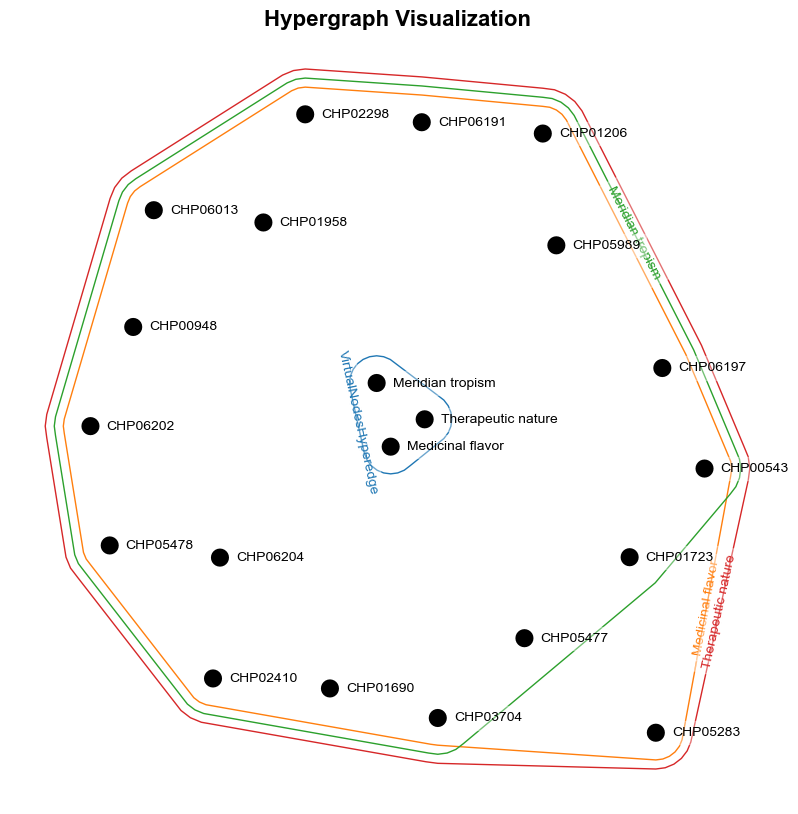

Hypergraph cpm_id: CPM00076
Node Information:
Node: Medicinal flavor
Node Feature: tensor([ 0.3062,  0.0472,  0.0000,  0.0000,  0.6467,  0.0454,  0.5539,  0.0390,
        -0.1017,  0.3170,  0.8542, -0.0477,  0.4464, -0.3088,  0.1377, -0.0349,
        -0.0058,  0.0080, -0.0288,  0.0163, -0.0062, -0.0080,  0.0153,  0.0071,
        -0.0202,  0.0042, -0.0195,  0.0218,  0.0252, -0.0153, -1.1367,  0.3897,
         0.9994, -0.4287,  0.9560,  0.1015,  0.6011,  0.8638, -0.0649,  1.5254,
         0.2556, -0.9779, -0.5747, -0.7539,  0.2587,  1.3523,  0.1876, -0.1078,
        -0.2236, -0.1678,  0.4648, -0.9857, -0.2606,  2.0117, -0.1819,  0.2933,
         0.5000, -0.0760,  0.4175, -1.0631,  0.0497, -0.1312, -0.1549, -0.0639,
        -0.0047,  0.0556,  0.2094,  0.0130, -0.4538,  0.0355,  0.2852,  0.0461,
        -0.1111, -0.0513, -0.0585, -0.0141, -0.1560, -0.0707, -0.3413,  0.2071,
        -0.2860, -0.2425, -0.1518,  0.1357,  0.1217,  0.1629, -0.2737, -0.0833,
         0.1838, -0.3235,  0.0000])
N

In [3]:
import matplotlib.pyplot as plt
import hypernetx as hnx
import torch
import os

# Set working directory and define input/output paths
work_dir = os.getcwd()  # Use the current directory as work_dir
input_data_dir = os.path.join(work_dir, '../Data')  # Set ../Data as input data location
output_dir = os.path.join(work_dir, '../Data')  # Set ../Data as input data location

hypergraph_file = os.path.join(input_data_dir, 'all_graphs_to_be_predicted.pkl')
hypergraphs = torch.load(hypergraph_file)  # Load the hypergraph list from file

# Define a function to optimize and draw the hypergraph visualization
def draw_optimized_hypergraph(hypergraph):
    fig, ax = plt.subplots(figsize=(10, 10))  # Set larger figure size for better visualization
    
    # Draw hypergraph using HypernetX, adding labels
    hnx.draw(
        hypergraph,
        with_edge_labels=True,    # Show edge (hyperedge) labels
        with_node_labels=True,    # Show node labels
        ax=ax                     # Draw on the specified axis
    )
    
    # Customize node style
    for node in hypergraph.nodes:
        # Find and modify node appearance using matplotlib Circle artists
        node_artist = ax.findobj(match=plt.Circle)
        for artist in node_artist:
            artist.set_color('skyblue')      # Set node fill color
            artist.set_edgecolor('black')    # Set node border color

    # Customize edge style
    for edge in hypergraph.edges:
        # Find and modify edge appearance using matplotlib Line2D artists
        edge_artist = ax.findobj(match=plt.Line2D)
        for artist in edge_artist:
            artist.set_color('green')        # Set edge color
            artist.set_linewidth(2.5)        # Set edge line width

    # Customize plot background and title
    ax.set_title('Hypergraph Visualization', fontsize=16, fontweight='bold')
    ax.set_facecolor('lightgray')  # Set background color
    
    plt.show()

# Display information about the nodes, edges, and labels of the hypergraph
def print_hypergraph_info(hypergraph):
    print("Hypergraph cpm_id:", getattr(hypergraph, 'cpm_id', 'No cpm_id'))  # Display cpm_id
    print("Node Information:")
    for node in hypergraph.nodes:
        print(f"Node: {node}")
        if hasattr(hypergraph, 'node_features'):
            print(f"Node Feature: {hypergraph.node_features.get(node, 'No feature')}")

    print("\nEdge Information:")
    for edge in hypergraph.edges:
        connected_nodes = hypergraph.edges[edge]
        print(f"Edge: {edge}, Connected Nodes: {connected_nodes}")
        if hasattr(hypergraph, 'edge_features'):
            print(f"Edge Feature: {hypergraph.edge_features.get(edge, 'No feature')}")

    # Print label information, if available
    if hasattr(hypergraph, 'labels'):
        print("\nLabel Information:")
        print(hypergraph.labels)

# Visualize and print information for the third hypergraph in the list
draw_optimized_hypergraph(hypergraphs[2])
print_hypergraph_info(hypergraphs[2])
